# Food Calorie Prediction from Images

This notebook implements a Convolutional Neural Network (CNN) model to predict the calorie content of food items from images. We'll use the NutritionVerse-Real dataset, which contains 889 images of 251 distinct dishes across 45 unique food types.

## Project Structure
1. Dataset Download & Exploration
2. Data Preprocessing & Augmentation 
3. CNN Model Architecture Design
4. Model Training & Evaluation
5. Gradio Interface Integration

Let's begin!

## 1. Environment Setup & Dataset Download

First, let's install the necessary packages and download the dataset from Kaggle.

In [1]:
# Install required packages
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn kaggle gradio pillow opencv-python

# Set up Kaggle API credentials (you need to upload your kaggle.json file)
import os
import json

# Uncomment the following if you're in Google Colab
# uploaded = files.upload()  # Upload kaggle.json
# os.makedirs('/root/.kaggle', exist_ok=True)
# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     f.write(json.dumps(json.loads(next(iter(uploaded.values())).decode())))
# os.chmod('/root/.kaggle/kaggle.json', 600)

# For local environment, ensure your kaggle.json is in ~/.kaggle/ with proper permissions


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos if x.device_type == 'GPU']

2025-06-01 10:29:17.856367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748773757.869045   26879 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748773757.873176   26879 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748773757.883394   26879 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748773757.883406   26879 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748773757.883408   26879 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1


I0000 00:00:1748773760.484587   26879 gpu_device.cc:2019] Created device /device:GPU:0 with 46866 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:09:00.0, compute capability: 8.6


['/device:GPU:0']

In [3]:
# Download the NutritionVerse-Real dataset
# !kaggle datasets download -d nutritionverse/nutritionverse-real --force
# !unzip -q nutritionverse-real.zip -d nutritionverse-data

## 2. Data Exploration & Understanding

Let's explore the dataset structure and examine some sample images and metadata.

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json

# Setting paths
base_path = 'nutritionverse-data'
images_path = os.path.join(base_path, 'nutritionverse-manual/nutritionverse-manual/images')
metadata_path = os.path.join(base_path, 'nutritionverse_dish_metadata3.csv')
coco_json_path = os.path.join(base_path, 'nutritionverse-manual/nutritionverse-manual/images/_annotations.coco.json')
splits_path = os.path.join(base_path, 'nutritionverse-manual/nutritionverse-manual/updated-manual-dataset-splits.csv')

# Load COCO format image metadata
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

print(f"COCO metadata loaded with {len(coco_data['images'])} images and {len(coco_data['annotations'])} annotations")

# Optionally extract image information from COCO format
coco_images = pd.DataFrame(coco_data['images'])
print("COCO images structure:")
print(coco_images.columns.tolist())

# Create a mapping from image_id to file_name
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
print(f"Created mapping for {len(image_id_to_filename)} image IDs to filenames")

# Load dataset splits if available
if os.path.exists(splits_path):
    splits_df = pd.read_csv(splits_path)
    print(f"Dataset splits loaded with {len(splits_df)} entries")
    print(f"Split distribution: {splits_df['category'].value_counts().to_dict()}")
else:
    print("Dataset splits file not found. Will use random splitting.")
    splits_df = None

# Load metadata
metadata_df = pd.read_csv(metadata_path)

# Display first few rows of metadata
print("Dataset Metadata Overview:")
print(f"Total entries: {len(metadata_df)}")
metadata_df.head()

COCO metadata loaded with 905 images and 4392 annotations
COCO images structure:
['id', 'license', 'file_name', 'height', 'width', 'date_captured']
Created mapping for 905 image IDs to filenames
Dataset splits loaded with 889 entries
Split distribution: {'Train': 624, 'Val': 265}
Dataset Metadata Overview:
Total entries: 251


,dish_id,total_food_weight,total_calories,total_fats,total_carbohydrates,total_protein,total_calcium,total_iron,total_magnesium,total_potassium,...,fat(g)_7,carbohydrates(g)_7,protein(g)_7,calcium(mg)_7,iron(mg)_7,magnesium(mg)_7,potassium(mg)_7,sodium(mg)_7,vitamin_d(µg)_7,vitamin_b12(µg)_7
0,1,165.0,95.73,0.3336,22.7958,0.5049,0.01233,0.000199,0.00888,0.19104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,127.0,186.99,1.8662,21.1603,19.8902,0.11461,0.001804,0.05289,0.24050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,156.0,92.04,0.3120,21.9336,0.4212,0.00936,0.000172,0.00780,0.16224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,84.0,74.76,0.7224,0.0000,15.9600,0.08064,0.000244,0.03612,0.19320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,307.0,399.10,16.3631,42.4888,20.0778,0.34077,0.003899,0.06447,0.55874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# add category to annotation df
annotation = coco_data['annotations']
category = coco_data['categories']
#each annotation consist of id, image_id, category_id, bbox, area, and segmentation(array of array )

for a in annotation:
    a['category'] = category[a['category_id']]['name']

In [6]:
# # Exploring the distribution of food types and nutritional values
# plt.figure(figsize=(12, 5))

# # Distribution of calories
# plt.subplot(1, 2, 1)
# sns.histplot(metadata_df['total_calories'], kde=True)
# plt.title('Distribution of Calories')
# plt.xlabel('Calories')


# plt.tight_layout()
# plt.show()

In [7]:
# from PIL import Image
# import numpy as np
# import random

# # Display sample images from the dataset
# import matplotlib.pyplot as plt

# # Select 6 random image IDs from the mapping
# sample_image_ids = random.sample(list(image_id_to_filename.keys()), 6)

# # Create a figure to display the images
# plt.figure(figsize=(15, 10))

# # Loop through the selected image IDs and display each image
# for i, img_id in enumerate(sample_image_ids):
#     # Get the filename for this image ID
#     filename = image_id_to_filename[img_id]
    
#     # Construct the full path to the image
#     img_path = os.path.join(images_path, filename)
    
#     # Try to find the corresponding metadata (calorie info)
#     img_metadata = None
#     for idx, row in metadata_df.iterrows():
#         if 'image_id' in row and row['image_id'] == img_id:
#             img_metadata = row
#             break
    
#     # Load and display the image
#     try:
#         img = Image.open(img_path)
#         plt.subplot(2, 3, i+1)
#         plt.imshow(np.array(img))
        
#         # Add title with food type and calories if available
#         title = f"Image ID: {img_id}\n"
#         if img_metadata is not None and 'total_calories' in img_metadata:
#             title += f"Calories: {img_metadata['total_calories']:.1f} kcal\n"
#         if img_metadata is not None and 'food_item_type_1' in img_metadata:
#             title += f"Food: {img_metadata['food_item_type_1']}"
            
#         plt.title(title)
#         plt.axis('off')
#     except Exception as e:
#         plt.subplot(2, 3, i+1)
#         plt.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
#                  horizontalalignment='center', verticalalignment='center')
#         plt.axis('off')

# plt.tight_layout()
# plt.suptitle("Sample Food Images from Dataset with Calorie Information", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.show()

In [8]:
import matplotlib.patches as patches

# Function to visualize image segmentation with labels
def visualize_segmentation_with_labels(image_ids, coco_data, image_id_to_filename, images_path):
    plt.figure(figsize=(20, 10))
    
    for i, img_id in enumerate(image_ids):
        # Get the filename for this image ID
        filename = image_id_to_filename[img_id]
        img_path = os.path.join(images_path, filename)
        
        # Load the image
        img = Image.open(img_path)
        
        # Get annotations for this image
        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]
        
        # Plot the image
        ax = plt.subplot(2, 2, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Image ID: {img_id}")
        
        # Add bounding boxes, segmentation, and labels
        for ann in annotations:
            bbox = ann['bbox']
            segmentation = ann['segmentation']
            category = ann['category']
            
            # Draw bounding box
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add label for category_id
            ax.text(
                bbox[0], bbox[1] - 5, f"ID: {category}",
                color='red', fontsize=10, backgroundcolor='white'
            )
            
            # Draw segmentation (if available)
            for seg in segmentation:
                poly = np.array(seg).reshape((-1, 2))
                ax.plot(poly[:, 0], poly[:, 1], 'g-', linewidth=2)
    
    plt.tight_layout()
    plt.show()

# Select 4 random image IDs
# selected_image_ids = random.sample(list(image_id_to_filename.keys()), 4)

# # Visualize segmentation with labels
# visualize_segmentation_with_labels(selected_image_ids, coco_data, image_id_to_filename, images_path)

# Food Detection with CNN

In this section, we'll train a CNN model to detect and classify different food items in images using the segmentation data from the dataset. We'll use the segmented regions of food items along with their category labels for training.

In [9]:
# Import necessary libraries for image processing and model building
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from  tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input 
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
from tqdm import tqdm
import random
import pandas as pd

# Define constants
IMG_SIZE = 224  # Input size for MobileNetV2
NUM_CLASSES = len(coco_data['categories'])

# Function to extract and preprocess food regions based on segmentation
def extract_food_regions(image_ids, coco_data, image_id_to_filename, images_path):
    X = []  # Cropped food images
    y = []  # Food category labels
    
    progress_bar = tqdm(image_ids)
    for img_id in progress_bar:
        try:
            # Get the filename for this image ID
            filename = image_id_to_filename[img_id]
            img_path = os.path.join(images_path, filename)
            
            # Load the image
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Get annotations for this image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]
            
            for ann in annotations:
                category_id = ann['category_id']
                bbox = ann['bbox']  # [x, y, width, height]
                
                # Extract region using bounding box
                x, y_coord, w, h = [int(v) for v in bbox]
                
                # Ensure coordinates are within image boundaries
                x = max(0, x)
                y_coord = max(0, y_coord)
                w = min(w, image.shape[1] - x)
                h = min(h, image.shape[0] - y_coord)
                
                if w <= 0 or h <= 0:
                    continue
                
                # Extract the region
                food_region = image[y_coord:y_coord+h, x:x+w]
                
                # Resize to standard size
                food_region = cv2.resize(food_region, (IMG_SIZE, IMG_SIZE))
                
                # Normalize pixel values
                # food_region = food_region / 255.0
                food_region = preprocess_input(food_region)
                
                # Add to dataset
                X.append(food_region)
                y.append(category_id)
                
        except Exception as e:
            print(f"Error processing image {img_id}: {e}")
    
    return np.array(X), np.array(y)


# Read the CSV file with train-test split information
print("Loading train-test split from CSV file...")
try:
    split_df = pd.read_csv('nutritionverse-data/nutritionverse-manual/nutritionverse-manual/updated-manual-dataset-splits.csv', header=None)
    split_df.columns = ['file_name', 'category']
    
    # Create dictionaries for train and test splits
    train_filenames = set(split_df[split_df['category'] == 'Train']['file_name'])
    test__filenames = set(split_df[split_df['category'] == 'Val']['file_name'])
    
    print(f"Found {len(train_filenames)} training images and {len(test__filenames)} test images in the split file")
except Exception as e:
    print(f"Error loading split file: {e}")
    print("Will fall back to random train-test split")
    train_filenames = None
    test__filenames = None

# Function to split the dataset and extract food regions
def prepare_train_test_data(coco_data, image_id_to_filename, images_path, train_filenames, test_filenames):
    # Get all image IDs
    all_image_ids = [img['id'] for img in coco_data['images']]
    
    # Get train and test image IDs based on predefined splits
    if train_filenames is not None and test_filenames is not None:
        train_image_ids = [img_id for img_id in all_image_ids if image_id_to_filename[img_id] in train_filenames]
        test_image_ids = [img_id for img_id in all_image_ids if image_id_to_filename[img_id] in test_filenames]
    else:
        # If no predefined splits, randomly split the dataset
        random.shuffle(all_image_ids)
        split_index = int(0.8 * len(all_image_ids))  # 80% for training, 20% for testing
        train_image_ids = all_image_ids[:split_index]
        test_image_ids = all_image_ids[split_index:]
    
    print(f"Using {len(train_image_ids)} training images and {len(test_image_ids)} testing images.")
    
    # Extract food regions for training and testing datasets
    print("Extracting food regions for training dataset...")
    X_train, y_train = extract_food_regions(train_image_ids, coco_data, image_id_to_filename, images_path)
    
    print("Extracting food regions for testing dataset...")
    X_test, y_test = extract_food_regions(test_image_ids, coco_data, image_id_to_filename, images_path)
    
    return X_train, y_train, X_test, y_test

# Prepare the train and test datasets
X_train, y_train, X_test, y_test = prepare_train_test_data(
    coco_data, image_id_to_filename, images_path, train_filenames, test__filenames
)

# Print dataset shapes
print(f"Training dataset: {X_train.shape}, {y_train.shape}")
print(f"Testing dataset: {X_test.shape}, {y_test.shape}")


Loading train-test split from CSV file...
Found 624 training images and 265 test images in the split file
Using 624 training images and 265 testing images.
Extracting food regions for training dataset...


100%|██████████| 624/624 [00:36<00:00, 17.03it/s]


Extracting food regions for testing dataset...


100%|██████████| 265/265 [00:09<00:00, 28.04it/s]

Training dataset: (2954, 224, 224, 3), (2954,)
Testing dataset: (1352, 224, 224, 3), (1352,)


I0000 00:00:1748773807.078855   26879 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46866 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:09:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │        23,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,730,576 (18.05 MB)

 Trainable params: 679,981 (2.59 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64


I0000 00:00:1748773816.795662   27509 service.cc:152] XLA service 0x7f0760001d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748773816.795700   27509 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-06-01 10:30:16.973226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748773818.241229   27509 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-06-01 10:30:19.568335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11325', 60 bytes spill stores, 60 bytes spill loads

2025-06-01 10:30:19.568376: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11325', 56 

 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0234 - loss: 4.9123 

I0000 00:00:1748773831.039640   27509 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-01 10:30:33.813908: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11325', 232 bytes spill stores, 232 bytes spill loads

2025-06-01 10:30:33.878242: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11453', 536 bytes spill stores, 536 bytes spill loads

2025-06-01 10:30:35.099802: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-01 10:30:35.212462: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measure

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0492 - loss: 4.6285

2025-06-01 10:30:57.911898: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2062', 204 bytes spill stores, 204 bytes spill loads

2025-06-01 10:30:57.929649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2062_0', 464 bytes spill stores, 1372 bytes spill loads

2025-06-01 10:30:58.316587: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2062', 5616 bytes spill stores, 5612 bytes spill loads

2025-06-01 10:30:58.508673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2062', 5356 bytes spill stores, 5336 bytes spill loads

2025-06-01 10:30:59.99577

Epoch 1: loss = 4.3008, accuracy = 0.0778, val_loss = 3.4094, val_accuracy = 0.2382
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.0504 - loss: 4.6148 - val_accuracy: 0.2382 - val_loss: 3.4094 - learning_rate: 1.0000e-04
Epoch 2/64
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1797 - loss: 3.5464

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2: loss = 3.5464, accuracy = 0.1797, val_loss = 3.3916, val_accuracy = 0.2441
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1797 - loss: 3.5464 - val_accuracy: 0.2441 - val_loss: 3.3916 - learning_rate: 1.0000e-04
Epoch 3/64
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.2093 - loss: 3.3453Epoch 3: loss = 3.0810, accuracy = 0.2608, val_loss = 3.0060, val_accuracy = 0.4445
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 792ms/step - accuracy: 0.2114 - loss: 3.3343 - val_accuracy: 0.4445 - val_loss: 3.0060 - learning_rate: 1.0000e-04
Epoch 4/64
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.2969 - loss: 3.0210Epoch 4: loss = 3.0210, accuracy = 0.2969, val_loss = 2.9897, val_accuracy = 0.4497
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2969 - loss: 3.0210 - val_accuracy: 0.4497 - val_loss: 2.9897 - learning_rate: 1.0000e-04
Epoch 5/64
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.3628 - loss: 2.5469Epoch 5: loss = 2.3583, accuracy = 0.4023, val_loss = 2.630

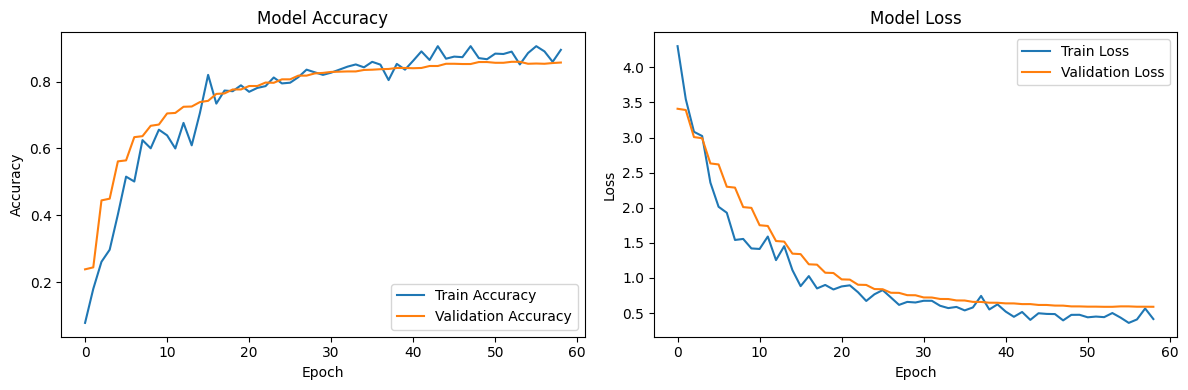

In [10]:
# Build a CNN model for food detection
import logging
import time
from  tensorflow.keras.applications import EfficientNetB0
BATCH_SIZE = 128
EPOCHS = 64
TIMESTAMP = int(time.time())
# Create a dynamic log file name
full_name = f"EfficientNetB0_NoTrain_E{EPOCHS}_B{BATCH_SIZE}_IMG{IMG_SIZE}"
log_file_name = f"{full_name}_TIMEP{TIMESTAMP}.log"

# Configure logging
logging.basicConfig(
    filename=log_file_name,  # Use the dynamic log file name
    level=logging.INFO,  # Log level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    force = True
)

# Custom callback to log training progress
class TrainingLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logging.info(
            f"Epoch {epoch + 1}: "
            f"loss = {logs.get('loss'):.4f}, "
            f"accuracy = {logs.get('accuracy'):.4f}, "
            f"val_loss = {logs.get('val_loss'):.4f}, "
            f"val_accuracy = {logs.get('val_accuracy'):.4f}"
        )
        print(
            f"Epoch {epoch + 1}: "
            f"loss = {logs.get('loss'):.4f}, "
            f"accuracy = {logs.get('accuracy'):.4f}, "
            f"val_loss = {logs.get('val_loss'):.4f}, "
            f"val_accuracy = {logs.get('val_accuracy'):.4f}"
        )


def build_food_detection_model(num_classes):
    # Use EfficientNetB0
    base_model = EfficientNetB0(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the model
model = build_food_detection_model(NUM_CLASSES)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5),
        TrainingLogger()
    ]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model.save(full_name+".h5")

# Testing

Testing food detection on image: dish_203_IMG_2108_jpeg.rf.b94aa06727d6e863e973a8ff680a13a6.jpg


2025-06-01 10:40:39.138207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 232 bytes spill stores, 232 bytes spill loads

2025-06-01 10:40:39.242808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043_0', 404 bytes spill stores, 1288 bytes spill loads

2025-06-01 10:40:39.630469: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 5524 bytes spill stores, 5564 bytes spill loads

2025-06-01 10:40:39.715297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 5352 bytes spill stores, 5352 bytes spill loads

2025-06-01 10:40:41.12567

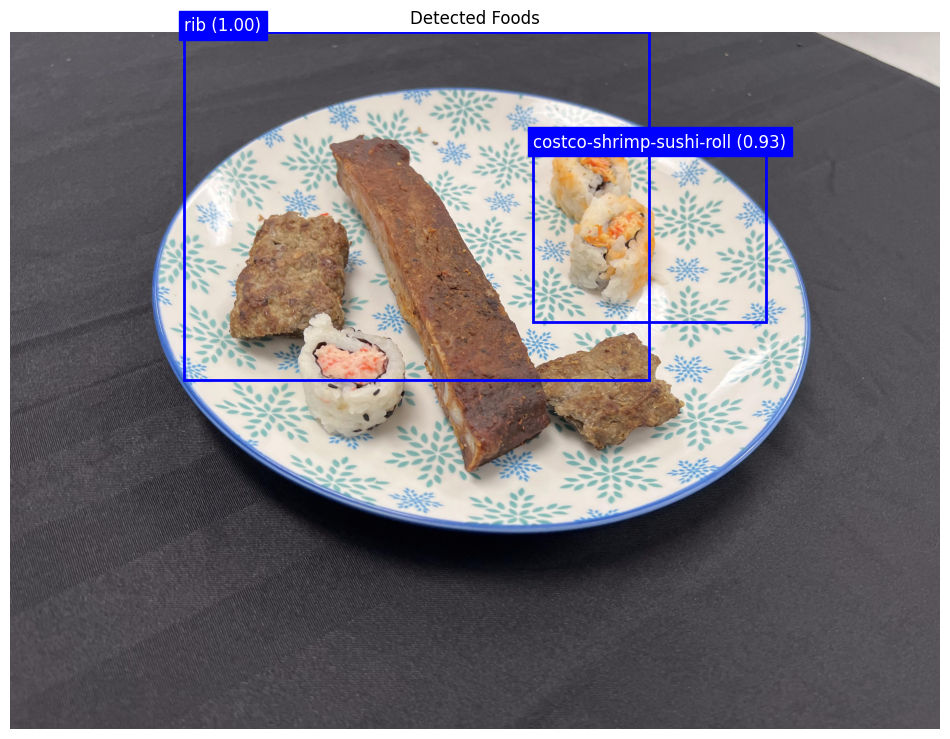

Detected 2 food items in total.
Detected food items:
1. rib (Confidence: 1.00)
2. costco-shrimp-sushi-roll (Confidence: 0.93)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.efficientnet import preprocess_input 
import numpy as np
import cv2
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder

def detect_food_in_image(image_path, model, label_encoder):
    import matplotlib.pyplot as plt
    import os

    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        return "Image not found."
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()

    IMG_SIZE = 224  # Ensure consistent size
    results = []

    # === Sliding Window Detection with Multiple Step Sizes ===
    window_sizes = [
        (image.shape[1] // 2, image.shape[0] // 2),
        (image.shape[1] // 3, image.shape[0] // 3),
        (image.shape[1] // 4, image.shape[0] // 4)
    ]
    step_divisors = [2, 4, 6, 8, 12]

    all_windows = []
    all_coords = []

    for win_w, win_h in window_sizes:
        if win_w < 50 or win_h < 50:
            continue
        for divisor in step_divisors:
            step_size = max(1, min(image.shape[0], image.shape[1]) // divisor)
            for y in range(0, image.shape[0] - win_h + 1, step_size):
                for x in range(0, image.shape[1] - win_w + 1, step_size):
                    window = original_image[y:y+win_h, x:x+win_w]
                    resized = cv2.resize(window, (IMG_SIZE, IMG_SIZE))
                    normalized = preprocess_input(resized)
                    all_windows.append(normalized)
                    all_coords.append((x, y, win_w, win_h))

    if not all_windows:
        print("No windows generated for prediction.")
        return []

    # === Batch Prediction ===
    batch_size = 64
    all_windows = np.stack(all_windows)
    predictions = []
    for i in range(0, len(all_windows), batch_size):
        batch = all_windows[i:i+batch_size]
        preds = model.predict(batch, verbose=0)
        predictions.extend(preds)

    # === Process Predictions ===
    sliding_window_results = []
    for pred, (x, y, w, h) in zip(predictions, all_coords):
        class_idx = np.argmax(pred)
        confidence = pred[class_idx]
        if confidence < 0.9:
            continue
        predicted_class = label_encoder.inverse_transform([class_idx])[0]
        category_name = next((cat['name'] for cat in coco_data['categories'] if cat['id'] == predicted_class), "Unknown")
        sliding_window_results.append({
            'class_idx': class_idx,
            'category': category_name,
            'confidence': float(confidence),
            'bbox': [x, y, w, h]
        })

    # === Non-Maximum Suppression (NMS) ===
    sliding_window_results.sort(key=lambda x: x['confidence'], reverse=True)
    keep_results = []

    for current in sliding_window_results:
        x1, y1, w1, h1 = current['bbox']
        x2, y2 = x1 + w1, y1 + h1
        overlaps = False
        for kept in keep_results:
            x3, y3, w2, h2 = kept['bbox']
            x4, y4 = x3 + w2, y3 + h2
            inter_x = max(0, min(x2, x4) - max(x1, x3))
            inter_y = max(0, min(y2, y4) - max(y1, y3))
            intersection = inter_x * inter_y
            union = w1 * h1 + w2 * h2 - intersection
            iou = intersection / union if union > 0 else 0
            if iou > 0.05 and current['category'] == kept['category']:
                overlaps = True
                break
        if not overlaps:
            keep_results.append(current)

    # === Visualization ===
    plt.figure(figsize=(12, 12))
    plt.imshow(original_image)
    plt.title("Detected Foods")
    for result in keep_results:
        x, y, w, h = result['bbox']
        category_name = result['category']
        confidence = result['confidence']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x, y - 5, f"{category_name} ({confidence:.2f})",
                 color='white', fontsize=12, backgroundcolor='blue')
        results.append({
            'category': category_name,
            'confidence': confidence,
            'bbox': [x, y, w, h]
        })
    plt.axis('off')
    plt.show()

    print(f"Detected {len(results)} food items in total.")
    return results


category = coco_data['categories']
# Extract only the 'id' values from the categories
category_ids = [cat['id'] for cat in category]

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(category_ids)

# Test the detection on a sample image
sample_image_id = random.choice(list(image_id_to_filename.keys()))
sample_filename = image_id_to_filename[sample_image_id]
sample_image_path = os.path.join(images_path, sample_filename)

print(f"Testing food detection on image: {sample_filename}")

# Predict food categories
detected_foods = detect_food_in_image(sample_image_path, model, label_encoder)

print("Detected food items:")
for i, food in enumerate(detected_foods):
    print(f"{i+1}. {food['category']} (Confidence: {food['confidence']:.2f})")